In [1]:
import json
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
import numpy as np


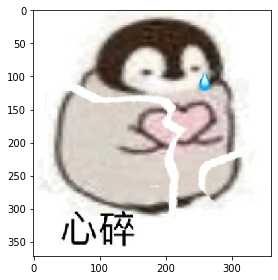

In [14]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

from skimage import io
image = io.imread('http://ww4.sinaimg.cn/orj360/814268e3gy1ge16cxkfycj20c80cnglw.jpg')
io.imshow(image)
io.show()


In [2]:

def read_json(filename):
    data = [json.loads(line) for line in open(filename).readlines()]
    return data

def write_json(filename, data):
    f = open(filename, "w")
    for r in data:
        s = json.dumps(r,ensure_ascii=False)
        f.write(s + "\n")


In [3]:
# 把爬虫数据数据合并到expression

import uuid

def create_expression_item(url, des):
    id  = str(uuid.uuid1())
    item = {
        "_id": id 
        , "time": "xxxx"
        , "tags": {}
        , "open_id": id 
        , "id": id
        , "file_id": url
        , "des_num": 0
        , "tag_num": 0
        , "description": des
        , "public": True
    }
    return item

def merge(targetname, sourcename):
    raw_data = read_json(targetname)
    new_data = read_json(sourcename)
    new_data2 = [create_expression_item(item[0],item[1]) for item in new_data]
    merge1 = {item["file_id"]:item for item in raw_data}
    merge2 = {item["file_id"]:item for item in new_data2}
    
    for key in merge2:
        merge1[key] = merge2[key]
    data = [merge1[key] for key in merge1]
    write_json(targetname,data)

merge("expression.json", "result.json")


In [4]:
# 训练expression

data = read_json("expression.json")
all_des = []
for item in data:
    try:
        all_des += item["description"]
    except:
        pass

sent_words = [list(jieba.cut(sent0)) for sent0 in all_des]
document = [" ".join(sent0) for sent0 in sent_words]
tfidf_model = TfidfVectorizer().fit(document)
sparse_result = tfidf_model.transform(document)
d = tfidf_model.vocabulary_
dictionary = [item2[0] for item2 in sorted(d.items(), key=lambda item:item[1])]


def get_max_index(nums, num):
    # nums=[1,8,2,23,7,-4,18,23,42,37,2]
    temp=[]
    Inf = 0
    nums = list(nums)
    for i in range(num):
        index = nums.index(max(nums))
        if index == 0:
            break
        temp.append(index)
        nums[nums.index(max(nums))]=Inf
    temp.sort()
    return temp


def des2tags(dess, num):
    doc = [" ".join(list(jieba.cut(sent))) for sent in dess]
    sparse_result = tfidf_model.transform(doc)

    # print(sparse_result)
    sum = np.zeros_like(sparse_result.toarray()[0])
    for item in sparse_result.toarray():
        sum += item
    tags_index = get_max_index(sum, num)
    tags = [dictionary[index] for index in tags_index]
    return tags
        # print(tags_index, tags)

print(des2tags([all_des[0]], 4))
for item in data:
    try:
        des = item["description"]
        tags = des2tags(des, 20)
        for tag in tags:
            item["tags"].setdefault(tag,0)
        item["des_num"] = len(des)
    except:
        print("error")
        pass
write_json("expression.json",data)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/vl/xsg_5gxn0lxgrbwy4rz9cdgr0000gn/T/jieba.cache
Loading model cost 3.575 seconds.
Prefix dict has been built succesfully.
['老子', '表情', '鱼塘']
